<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%202/Case_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [39]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/diabetic_data.csv")
ID_map = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/IDs_mapping.csv")

admission_source = ID_map.drop(['admission_description', 'discharge_description'], axis=1)
admission = ID_map.drop(['admission_source_description', 'discharge_description'], axis=1)
discharge = ID_map.drop(['admission_description', 'admission_source_description'], axis=1)

df=pd.merge(df, admission, 
            left_on='admission_type_id', 
            right_on='id', 
            how='left' 
)


df=pd.merge(df, discharge, 
            left_on='discharge_disposition_id', 
            right_on='id', 
            how='left' 
)
df=pd.merge(df, admission_source, 
            left_on='admission_source_id', 
            right_on='id', 
            how='left' 
)


Upon first inspection there do not appear to be any NAs

In [40]:
#sorting the dataframe by patient_nbr and encounter_id, in order to filter out the repeat values 
df=df.sort_values(by=['patient_nbr', 'encounter_id'])

#filtering out repeat values by patient_nbr
df=df.groupby('patient_nbr').first()
len(df)

71518

In [41]:
df = df[df.columns.drop(list(df.filter(regex='_x')))]
df = df[df.columns.drop(list(df.filter(regex='_y')))]
df = df[df.columns.drop(list(df.filter(regex='_id')))]

#removing number emergency, as it is tied to the readmission column we are predicting on
#df = df[df.columns.drop(list(df.filter(regex='number_emergency')))]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 135 to 189502619
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   race                          71518 non-null  object
 1   gender                        71518 non-null  object
 2   age                           71518 non-null  object
 3   weight                        71518 non-null  object
 4   time_in_hospital              71518 non-null  int64 
 5   payer_code                    71518 non-null  object
 6   medical_specialty             71518 non-null  object
 7   num_lab_procedures            71518 non-null  int64 
 8   num_procedures                71518 non-null  int64 
 9   num_medications               71518 non-null  int64 
 10  number_outpatient             71518 non-null  int64 
 11  number_emergency              71518 non-null  int64 
 12  number_inpatient              71518 non-null  int64 
 13  diag_1    

In [42]:
df.head()

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),?,8,?,Cardiology,77,6,33,...,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,1,Physician Referral
378,Caucasian,Female,[50-60),?,2,?,Surgery-Neuro,49,1,11,...,No,No,No,No,No,NO,Elective,Discharged to home,1,Physician Referral
729,Caucasian,Female,[80-90),?,4,MC,InternalMedicine,68,2,23,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,7,Emergency Room
774,Caucasian,Female,[80-90),?,3,?,InternalMedicine,46,0,20,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
927,AfricanAmerican,Female,[30-40),?,5,?,InternalMedicine,49,0,5,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room


The weight column has a question mark (?), corresponding to missing weights, these are effectively NAs.
Also, target is not binary in this case, however, our aim is to predict rehospitalization within 30 days, a binary (yes or no) response.


In [43]:
# Get count duplicates single column using dataframe.pivot_table()
df2 = df.pivot_table(index = ['patient_nbr'], aggfunc ='size')
print(df2)

patient_nbr
135          1
378          1
729          1
774          1
927          1
            ..
189351095    1
189365864    1
189445127    1
189481478    1
189502619    1
Length: 71518, dtype: int64


When we look at the data by patient number, we can see that the number of rows drops from 101,766 down to 71,518. We will be dropping the repeated values.

In [44]:
for i in df.columns:
  count = df.loc[df[i]=='?',i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))

race: 2.72%
weight: 96.01%
payer_code: 43.41%
medical_specialty: 48.21%
diag_1: 0.02%
diag_2: 0.41%
diag_3: 1.71%


Three variables have a large percentage of missing values, Weight, Payer_code and Medical_speciatly with about 97%, 40% and 49% of missing values accordingly. Race and diags 1-3 all have a smaller number of missing values.

In [45]:
#dropping columns with high # of missing values
df=df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1)


In [46]:
# Replacing the ? with nan
df=df.replace("?", np.nan)

In [47]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,id
count,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,5.657457
std,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,4.162580
min,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,1.000000
50%,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,7.000000
75%,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,7.000000
max,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,25.000000


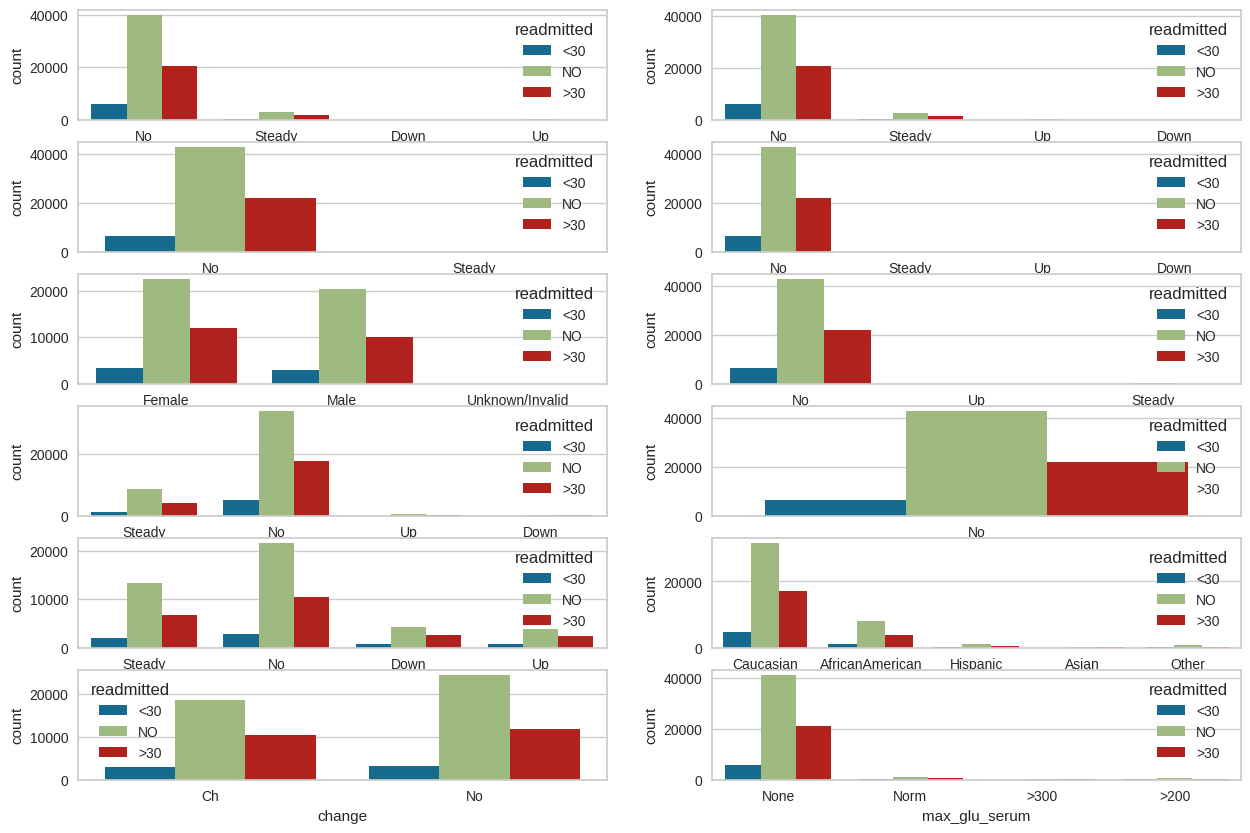

In [48]:
fig, axes = plt.subplots(6,2, figsize = (15, 10))

sns.countplot(x = 'pioglitazone', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 1]);

sns.countplot(x = 'metformin-rosiglitazone', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'miglitol', data = df, hue = 'readmitted', ax = axes[1, 1]);

sns.countplot(x = 'gender', data = df, hue = 'readmitted', ax = axes[2, 0]);
sns.countplot(x = 'acarbose', data = df, hue = 'readmitted', ax = axes[2, 1]);

sns.countplot(x = 'metformin', data = df, hue = 'readmitted', ax = axes[3, 0]);
sns.countplot(x = 'citoglipton', data = df, hue = 'readmitted', ax = axes[3, 1]);

sns.countplot(x = 'insulin', data = df, hue = 'readmitted', ax = axes[4, 0]);
sns.countplot(x = 'race', data = df, hue = 'readmitted', ax = axes[4, 1]);

sns.countplot(x = 'change', data = df, hue = 'readmitted', ax = axes[5, 0]);
sns.countplot(x = 'max_glu_serum', data = df, hue = 'readmitted', ax = axes[5, 1]);

While we saw some differences in readmission by race, there was no measure of the confounding factors for implicit racial bias, therefore that variable was excluded as a factor from the model.

Other research has shown that African American's have lower medical intervention, but that has been an indication of racial bias within the medical community previously (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797360/_).

In [49]:
#df=df.drop(['race'], axis=1)
df=df.drop(['id'], axis=1)

In [50]:
df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),8,77,6,33,0,0,0,...,No,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,Physician Referral
378,Caucasian,Female,[50-60),2,49,1,11,0,0,0,...,No,No,No,No,No,No,NO,Elective,Discharged to home,Physician Referral
729,Caucasian,Female,[80-90),4,68,2,23,0,0,0,...,No,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,Emergency Room
774,Caucasian,Female,[80-90),3,46,0,20,0,0,0,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
927,AfricanAmerican,Female,[30-40),5,49,0,5,0,0,0,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room


In [51]:
#filtering out expired and hospice patients
df = df[df["discharge_description"] != 'Expired']
df = df[df["discharge_description"] != 'Expired at home. Medicaid only, hospice.']
df = df[df["discharge_description"] != 'Hospice / home']
df = df[df["discharge_description"] != 'Hospice / medical facility']

In [52]:
df[['readmitted','change']].groupby('change').describe()

readmitted                  
            count unique top   freq
change                             
Ch          31489      3  NO  18047
No          38474      3  NO  23428

In [53]:
df[['readmitted','admission_description']].groupby('admission_description').describe()

readmitted                  
                           count unique top   freq
admission_description                             
Elective                   13846      3  NO   8915
Emergency                  35671      3  NO  20777
Newborn                        9      3  NO      6
Not Available               3121      3  NO   1783
Not Mapped                   291      3  NO    201
Trauma Center                 18      1  NO     18
Urgent                     12847      3  NO   7583

Admission code 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-NotAvailable, 6-NULL, 7-Trauma Center, 8-NotMapped.
For Not Mapped and Null admission categories, the missing payer code is seen on almost all patients. Based on the levels of the payer code category, it would seem as if the missing value corresponds to patients who did not disclose a payment method (insurance or self-pay), which in itself, is a category level.

In [54]:
df.readmitted.value_counts()
# >30 does not count as within 30 days for our target, will replace

NO     41475
>30    22212
<30     6276
Name: readmitted, dtype: int64

In [55]:
#removing information from the dataframe, which are tied to information when patient was released from hospital
df =  df[df.columns.drop(list(df.filter(regex='discharge')))]
df = df[df.columns.drop(list(df.filter(regex='time_in_hospital')))]

#dropping cateorical columns with little to no variation
df=df.drop([ 'troglitazone','metformin-pioglitazone','rosiglitazone','acarbose','acetohexamide', 'citoglipton', 'glipizide-metformin', 'nateglinide', 'citoglipton', 'pioglitazone', 'tolbutamide', 'glyburide-metformin', 'tolazamide', 'glimepiride', 'miglitol', 'repaglinide', 'chlorpropamide', 'max_glu_serum', 'metformin-rosiglitazone'], axis=1)


In [56]:
y = df.readmitted.replace(to_replace='>30',value='NO')
y = label_binarize(y,classes=['NO','<30'])

In [57]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='_id')))]

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))
X


,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,diag_1_10,diag_1_11,diag_1_110,diag_1_112,diag_1_114,diag_1_115,...,admission_source_description_Transfer from Hospice,admission_source_description_Transfer from a hospital,admission_source_description_Unknown/Invalid,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1.715140,2.603322,2.091586,-0.262735,-0.20302,-0.292952,0.387808
378,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.307760,-0.242236,-0.563069,-0.262735,-0.20302,-0.292952,-2.110599
729,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1.262768,0.326875,0.884924,-0.262735,-0.20302,-0.292952,0.887489
774,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.156969,-0.811348,0.522926,-0.262735,-0.20302,-0.292952,0.887489
927,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.307760,-0.811348,-1.287065,-0.262735,-0.20302,-0.292952,-2.110599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1.514086,-0.242236,-0.563069,-0.262735,-0.20302,-0.292952,0.887489
189365864,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.659605,-0.242236,-0.925067,-0.262735,-0.20302,-0.292952,-0.111874
189445127,0,0,0,1,0,0,0,0,0,0,...,0,0,0,-0.194876,-0.811348,0.281594,-0.262735,-0.20302,-0.292952,0.887489


In [58]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['readmitted']]

y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_''>30')))]
y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_NO')))]

Descriptive_df = y_alt.join(df)

In [59]:
Descriptive_df

,readmitted_<30,race,gender,age,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glipizide,glyburide,examide,insulin,glimepiride-pioglitazone,change,diabetesMed,readmitted,admission_description,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,1,Caucasian,Female,[50-60),77,6,33,0,0,0,...,No,Down,No,Steady,No,Ch,Yes,<30,Urgent,Physician Referral
378,0,Caucasian,Female,[50-60),49,1,11,0,0,0,...,No,No,No,No,No,No,No,NO,Elective,Physician Referral
729,0,Caucasian,Female,[80-90),68,2,23,0,0,0,...,No,No,No,No,No,No,Yes,NO,Emergency,Emergency Room
774,0,Caucasian,Female,[80-90),46,0,20,0,0,0,...,No,Steady,No,No,No,Ch,Yes,NO,Emergency,Emergency Room
927,0,AfricanAmerican,Female,[30-40),49,0,5,0,0,0,...,No,No,No,No,No,No,Yes,NO,Emergency,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,Caucasian,Female,[80-90),73,1,11,0,0,0,...,No,No,No,No,No,No,No,NO,Emergency,Emergency Room
189365864,0,Other,Male,[60-70),56,1,8,0,0,0,...,No,No,No,Steady,No,No,Yes,NO,Emergency,Emergency Room
189445127,0,Caucasian,Female,[80-90),39,0,18,0,0,0,...,Up,No,No,Down,No,Ch,Yes,NO,Emergency,Emergency Room


In [60]:
Descriptive_df.groupby('race').mean()

<ipython-input-60-7ba3c24e3214>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Descriptive_df.groupby('race').mean()


,readmitted_<30,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
race,,,,,,,,
AfricanAmerican,0.086522,43.763014,1.264004,14.878932,0.165280,0.133111,0.147056,6.892005
Asian,0.084016,40.303279,1.258197,12.618852,0.147541,0.065574,0.159836,6.872951
Caucasian,0.091820,42.633331,1.471245,15.957772,0.316197,0.099451,0.185706,7.348940
Hispanic,0.081388,43.342228,1.163442,13.640427,0.223482,0.124083,0.216811,6.704470
Other,0.068696,42.832174,1.603478,14.793043,0.196522,0.092174,0.127826,6.980000


In [61]:
Descriptive_df.groupby('gender').mean()

<ipython-input-61-8b72f8c19356>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Descriptive_df.groupby('gender').mean()


,readmitted_<30,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
gender,,,,,,,,
Female,0.090289,42.787132,1.315326,15.767226,0.294265,0.113768,0.176951,7.229496
Male,0.089048,42.980174,1.550970,15.551550,0.262899,0.092745,0.175500,7.217626
Unknown/Invalid,0.000000,34.000000,2.666667,16.333333,0.000000,0.000000,0.000000,6.000000


In [62]:
grid = {'C':[10,12.5,20,50,100]}
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
model = LogisticRegression(random_state=42,class_weight='balanced',max_iter=3000)
search = GridSearchCV(model,grid,scoring='recall',cv = skf,n_jobs=-1)
results = search.fit(X,y.flatten())
print(results.best_score_)
print(results.best_params_)
# this finds C = 10.

0.5195995635293222
{'C': 50}


In [ ]:
accuracy = []

cv = KFold(n_splits=5,shuffle=True,random_state=42)
# Split the dataset into training and testing sets
for train, test in cv.split(X,y.flatten()):
    X_train, X_test = X.iloc[train],X.iloc[test]
    y_train, y_test = np.take(y.flatten(),train), np.take(y.flatten(),test)

    # Create a logistic regression model
    model = LogisticRegression(class_weight = "balanced",n_jobs=-1,max_iter = 3000, C=10)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

    #confusion matrix
    cr = classification_report(y_test,y_pred)
    print(cr)

              precision    recall  f1-score   support

           0       0.93      0.65      0.76     12695
           1       0.13      0.52      0.21      1298

    accuracy                           0.63     13993
   macro avg       0.53      0.58      0.48     13993
weighted avg       0.85      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.64      0.76     12765
           1       0.12      0.50      0.19      1228

    accuracy                           0.63     13993
   macro avg       0.52      0.57      0.47     13993
weighted avg       0.86      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     12735
           1       0.13      0.53      0.20      1258

    accuracy                           0.62     13993
   macro avg       0.53      0.58      0.48     13993
weighted avg       0.86      0.62      0.70     13993

              preci

In [ ]:
accuracy = []

cv = KFold(n_splits=5,shuffle=True,random_state=42)
# Split the dataset into training and testing sets
for train, test in cv.split(X,y.flatten()):
    X_train, X_test = X.iloc[train],X.iloc[test]
    y_train, y_test = np.take(y.flatten(),train), np.take(y.flatten(),test)

    # Create a logistic regression model
    model = LogisticRegression(penalty='l2', class_weight = "balanced",solver='newton-cholesky', n_jobs=-1,max_iter = 3000, C=10)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

    #confusion matrix
    cr = classification_report(y_test,y_pred)
    print(cr)
   

              precision    recall  f1-score   support

           0       0.93      0.65      0.76     12695
           1       0.13      0.52      0.21      1298

    accuracy                           0.63     13993
   macro avg       0.53      0.58      0.49     13993
weighted avg       0.86      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.64      0.76     12765
           1       0.12      0.50      0.19      1228

    accuracy                           0.63     13993
   macro avg       0.52      0.57      0.47     13993
weighted avg       0.86      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     12735
           1       0.13      0.53      0.20      1258

    accuracy                           0.62     13993
   macro avg       0.53      0.58      0.48     13993
weighted avg       0.86      0.62      0.70     13993

              preci

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


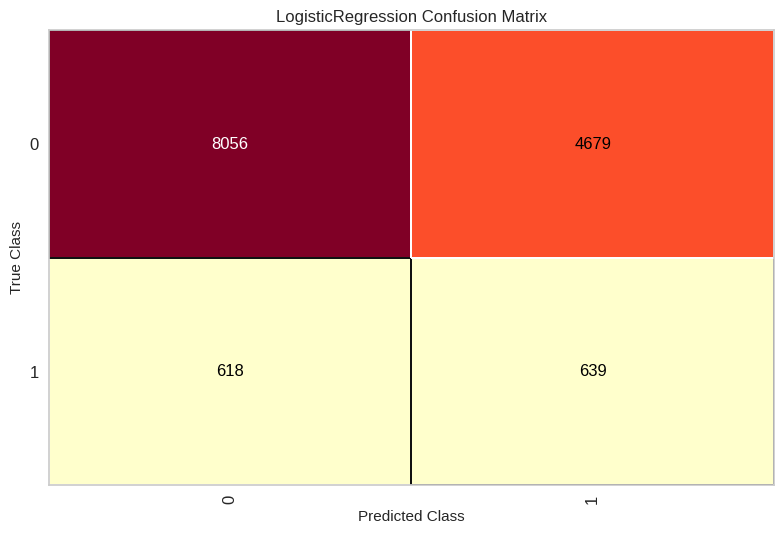

In [ ]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0, 1])

# Fit the model. 
cm.fit(X_train, y_train)

# Score runs predict() on the data and creates the confusion_matrix
cm.score(X_test, y_test)

cm.show();

In [ ]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
1757,diag_1_359,4.494590
984,diag_2_346,-4.483042
1332,diag_2_826,4.466343
1216,diag_2_654,4.450727
1317,diag_2_807,-4.320849
1267,diag_2_728,-4.076529
691,diag_3_E922,4.006024
510,diag_3_755,3.940950
1924,diag_1_570,3.888645
574,diag_3_861,3.884259
